确认设备以及cuda

In [5]:
import torch
from torch import cuda,optim 
print(torch.__version__);
print(torch.cuda.is_available())
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

2.6.0+cu126
True
cuda


0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [6]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader,random_split
df_train = pd.read_json('../weibo21_all.json', lines=True)
df_train.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_29456\304779165.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_train = pd.read_json('../weibo21_all.json', lines=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_29456\304779165.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_train = pd.read_json('../weibo21_all.json', lines=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_29456\304779165.py:3: FutureWarning: The behavior of 'to_datetime' with 'uni

,id,label,category,images,content,timestamp
0,100000,0,0,"[{'path': 'image/100000_0.jpg'}, {'path': 'ima...",【三星折叠屏原型机曝光：双屏设计/非柔性屏】网友@黎启lee晒出三星的ProjcetV可折叠...,1970-01-18 16:46:49.446
1,100001,0,0,[{'path': 'image/100001_0.jpg'}],【能电鱼，更能电力找鱼：别以为电鳗只有把鱼电晕一招！】电鳗2米长的身体里有许多专门发电的细胞...,1970-01-17 18:11:57.263
2,100002,0,0,[{'path': 'image/100002_0.jpg'}],在iPad2发售几小时后，国外玩家就已经对它进行了拆解。想了解如此轻薄的机身如何容纳下这么多...,1970-01-16 01:04:58.932
3,100003,0,0,[{'path': 'image/100003_0.jpg'}],#乐享时光#现在科学家都这么闲了吗?谢谢你告诉我这么重要的结论啊！（转）,1970-01-17 13:05:04.203
4,100004,0,0,[{'path': 'image/100004_0.jpg'}],全国首家“无人银行”亮相大堂经理是智能机器人银行里没有忙碌的工作人员和拥挤的排队客户，而是各...,1970-01-18 15:12:18.840


提取标签以及输入

In [7]:
X = df_train['content']
Y = df_train['label'] 
print(df_train['label'].unique())

[0 1]


加载bert作为分词模型

In [8]:
from transformers import AutoTokenizer
# 指定本地路径加载 tokenizer
tokenizer = AutoTokenizer.from_pretrained("E:/mod/bert-base-uncased")

In [9]:
from torch import nn
import torch
class SentimentDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        # 使用 BERT tokenizer 对句子进行编码，生成 input_ids
        encoding = self.tokenizer(
            self.sentences[idx],                      # 输入句子
            add_special_tokens=True,                  # 添加特殊 tokens (CLS, SEP)
            max_length=self.max_length,               # 设置最大长度
            padding='max_length',                     # 填充到最大长度
            truncation=True,                          # 截断长句子
            return_attention_mask=False,              # 不需要 attention mask，因为 RNN 不使用
            return_tensors='pt'                       # 返回 PyTorch tensors
        )
        
        input_ids = encoding['input_ids'].squeeze()  # 获得 input_ids
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # 标签转换为张量

        return input_ids, label


In [10]:
# 最大句子长度
max_length = 128

# 创建 Dataset 实例
train_dataset = SentimentDataset(X, Y, tokenizer=tokenizer, max_length=max_length)

# 设置训练集和验证集的比例，比如 80% 训练集，20% 验证集
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# 拆分数据集
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# 创建 DataLoader
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)


# 查看一个 batch 的数据
for batch in train_loader:
    input_ids, labels = batch  # 根据前面的实现，数据不再有 attention_masks
    print(input_ids.shape)  # (batch_size, max_len)
    print(labels.shape)  # (batch_size)
    break


torch.Size([64, 128])
torch.Size([64])


In [ ]:
# 这个 RNN 类采用了嵌入层、GRU 和全连接层的结构来进行序列建模。
# 1. 输入首先通过 nn.Embedding 将离散的词索引转换为连续的词向量表示；
# 2. 接着，将嵌入后的表示经过 dropout 处理，然后送入多层 GRU 网络中进行时序建模，
#    GRU 同样采用了 dropout 来防止过拟合；
# 3. 最后，仅取 GRU 最后一个时间步的输出，经过 dropout 后通过全连接层映射到输出空间，
#    一般用于分类或回归任务。
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=3, dropout=0.5):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True, dropout=dropout)
        self.dropout_layer = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        embed = self.embedding(input)  # (batch_size, seq_len, hidden_size)
        embed = self.dropout_layer(embed)  # Apply dropout to embeddings
        output, hidden = self.gru(embed, hidden)  # GRU with dropout
        output = self.dropout_layer(output)  # Apply dropout to GRU output
        output = self.linear(output[:, -1, :])  # Only take the output of the last time step
        return output, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state, shape should be (n_layers, batch_size, hidden_size)
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
        return hidden

In [12]:
# 定义模型参数
input_size = 30522  # BERT 词汇表的大小
hidden_size = 128   # 隐层大小
output_size = len(df_train['label'].unique())  # 类别数量
n_layers = 3        # GRU 层数
# 实例化模型
model = RNN(input_size, hidden_size, output_size, n_layers)
model.to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# 定义评估函数
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
def evaluate(model, val_loader):
    model.eval()  # 设置模型为评估模式
    predictions, true_labels = [], []
    
    with torch.no_grad():  # 不需要计算梯度
        for batch in val_loader:
            input_ids, labels = [x.to(device) for x in batch]
            
            # 初始化隐藏状态
            hidden = model.init_hidden(input_ids.size(0))
            
            # 前向传播
            outputs, hidden = model(input_ids, hidden)
            
            # 记录模型的预测值（取概率最大的类别）
            preds = F.softmax(outputs, dim=1).argmax(dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # 计算准确率
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

Epoch 1/100, Loss: 0.6827, Validation Accuracy: 0.5947
Epoch 2/100, Loss: 0.6708, Validation Accuracy: 0.6166
Epoch 3/100, Loss: 0.6222, Validation Accuracy: 0.7010
Epoch 4/100, Loss: 0.5788, Validation Accuracy: 0.6900
Epoch 5/100, Loss: 0.5414, Validation Accuracy: 0.7464
Epoch 6/100, Loss: 0.5249, Validation Accuracy: 0.7585
Epoch 7/100, Loss: 0.5059, Validation Accuracy: 0.7705
Epoch 8/100, Loss: 0.4800, Validation Accuracy: 0.7656
Epoch 9/100, Loss: 0.4554, Validation Accuracy: 0.7744
Epoch 10/100, Loss: 0.4409, Validation Accuracy: 0.7963
Epoch 11/100, Loss: 0.4244, Validation Accuracy: 0.7957
Epoch 12/100, Loss: 0.4172, Validation Accuracy: 0.7985
Epoch 13/100, Loss: 0.3980, Validation Accuracy: 0.7946
Epoch 14/100, Loss: 0.3825, Validation Accuracy: 0.7996
Epoch 15/100, Loss: 0.3657, Validation Accuracy: 0.8138
Epoch 16/100, Loss: 0.3612, Validation Accuracy: 0.8012
Epoch 17/100, Loss: 0.3440, Validation Accuracy: 0.8061
Epoch 18/100, Loss: 0.3358, Validation Accuracy: 0.8050
E

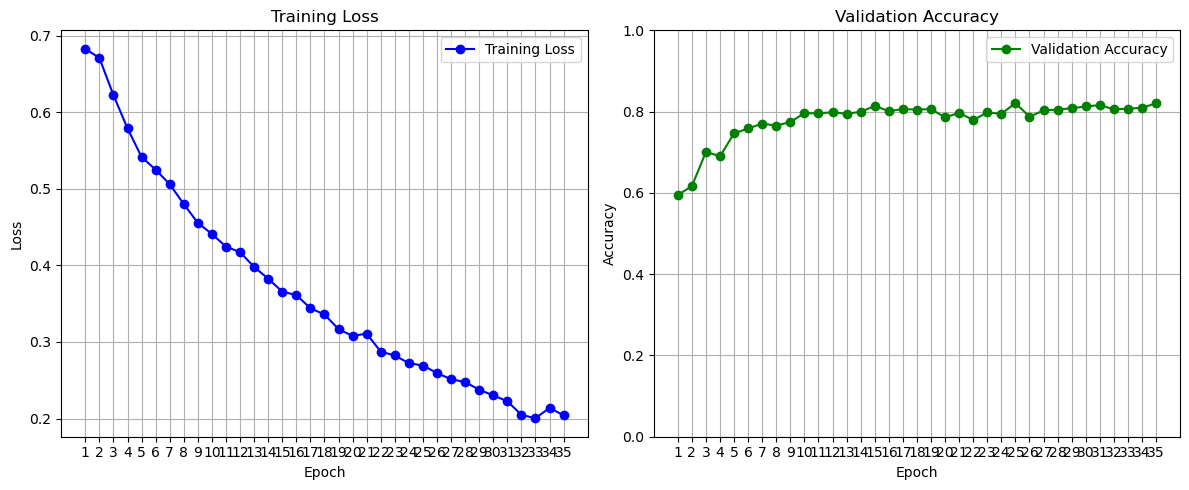

In [ ]:
import matplotlib.pyplot as plt

# 初始化存储损失和准确率的列表
train_losses = []
val_accuracies = []

# Early stopping parameters
patience = 10
best_val_accuracy = 0
patience_counter = 0

# 训练模型的代码
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    epoch_loss = 0  # 每个 epoch 的损失初始化为 0
    for batch in train_loader:
        input_ids, labels = [x.to(device) for x in batch]
        
        # 初始化隐藏状态
        hidden = model.init_hidden(input_ids.size(0))
        
        # 前向传播
        outputs, hidden = model(input_ids, hidden)
        
        # 计算损失
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # 累加当前 batch 的损失

    # 计算每个 epoch 的平均损失
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)  # 记录平均损失

    # 每个 epoch 后进行评估
    val_accuracy = evaluate(model, val_loader)
    val_accuracies.append(val_accuracy)  # 记录验证准确率
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping logic
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# 绘制损失和验证准确率图
plt.figure(figsize=(12, 5))

# 绘制损失图
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(train_losses) + 1))  # 设置 x 轴刻度
plt.grid()
plt.legend()

# 绘制验证准确率图
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', color='g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(val_accuracies) + 1))  # 设置 x 轴刻度
plt.ylim(0, 1)  # 限定 y 轴范围
plt.grid()
plt.legend()

plt.tight_layout()  # 自动调整子图参数
plt.show()  # 显示图


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 加载保存的最佳模型状态
model.load_state_dict(torch.load("./models/best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        # 二分类预测（阈值 0.5）
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='binary')  # 二分类情况

print("Validation Accuracy: {:.4f}".format(accuracy))
print("Validation F1 Score: {:.4f}".format(f1))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))